# La rotazione fattoriale {#sec-rotation}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
here::here("code", "_common.R") |>
    source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(lavaan, psych)

Caricamento dei namespace richiesti: pacman



Nel capitolo {ref}`extraction-notebook` abbiamo determinato il numero ottimale di fattori comuni. Tuttavia, la soluzione iniziale, non ruotata, può risultare difficile da interpretare. Per ottenere una struttura fattoriale più semplice e intuitiva, si procede alla rotazione degli assi fattoriali. L'obiettivo della rotazione è quello di identificare gruppi omogenei di variabili che saturano fortemente su un singolo fattore e con saturazioni trascurabili sugli altri.

## Indeterminatezza della soluzione fattoriale

La necessità di effettuare la rotazione deriva dal fatto che la matrice delle saturazioni non ha un’unica soluzione. Attraverso trasformazioni matematiche, è possibile ottenere infinite matrici dello stesso ordine. Questo fenomeno è noto come indeterminatezza della soluzione fattoriale.

La matrice delle saturazioni fattoriali $\boldsymbol{\Lambda}$ non è univocamente definita poiché non esiste una soluzione unica per determinare le saturazioni fattoriali. Una matrice di correlazioni $\boldsymbol{R}$ può produrre diverse soluzioni fattoriali, ovvero matrici con lo stesso numero di fattori comuni ma con diverse configurazioni di saturazioni fattoriali, o matrici di saturazioni fattoriali corrispondenti a un diverso numero di fattori comuni.

**Esempio.** Siano $\boldsymbol{\Lambda}_1$ e $\boldsymbol{\Lambda}_2$ due matrici
aventi lo stesso numero di righe e colonne, ma contenenti saturazioni
fattoriali diverse. $\boldsymbol{\Lambda}_1$ è definita dai valori
seguenti

In [2]:
l1 <- matrix(
  c(
    0.766,  -0.232,
    0.670,  -0.203,
    0.574,  -0.174,
    0.454,   0.533,
    0.389,   0.457,
    0.324,   0.381
  ),
  byrow = TRUE, ncol = 2
)

mentre per $\boldsymbol{\Lambda}_2$ abbiamo

In [3]:
l2 <- matrix(
  c(
    0.783,  0.163,
    0.685,  0.143,
    0.587,  0.123,
    0.143,  0.685,
    0.123,  0.587,
    0.102,  0.489
  ),
  byrow = TRUE, ncol = 2
)

Esaminiamo la matrice delle correlazioni riprodotte dalle due matrici di
pesi fattoriali (con le comunalità sulla diagonale di $\boldsymbol{R}$):

In [4]:
l1 %*% t(l1) |> round(2)

0.64,0.56,0.48,0.22,0.19,0.16
0.56,0.49,0.42,0.20,0.17,0.14
0.48,0.42,0.36,0.17,0.14,0.12
0.22,0.20,0.17,0.49,0.42,0.35
0.19,0.17,0.14,0.42,0.36,0.30
0.16,0.14,0.12,0.35,0.30,0.25


In [5]:
l2 %*% t(l2) |> round(2)

0.64,0.56,0.48,0.22,0.19,0.16
0.56,0.49,0.42,0.20,0.17,0.14
0.48,0.42,0.36,0.17,0.14,0.12
0.22,0.20,0.17,0.49,0.42,0.35
0.19,0.17,0.14,0.42,0.36,0.30
0.16,0.14,0.12,0.35,0.30,0.25


Come si vede, viene ottenuto lo stesso risultato utilizzando matrici
$\boldsymbol{\Lambda}$ con lo stesso numero $m$ di colonne ma
saturazioni fattoriali diverse.

Si consideri ora il caso di matrici $\boldsymbol{\Lambda}$
corrispondenti a soluzioni fattoriali con un diverso numero di fattori
comuni. Siano $\boldsymbol{\Lambda}_1$ e $\boldsymbol{\Lambda}_2$ due
matrici aventi lo stesso numero di righe ma un numero diverso di
colonne:

In [6]:
l1 <- matrix(
  c(
    0.9,
    0.7,
    0.5,
    0.3
  ),
  byrow = TRUE, ncol = 1
)

l2 <- matrix(
  c(
    0.78, 0.45,
    0.61, 0.35,
    0.43, 0.25,
    0.25, 0.15
  ),
  byrow = TRUE, ncol = 2
)

Si noti che la stessa matrice di correlazioni riprodotte (con le
comunalità sulla diagonale principale) viene generata dalle saturazioni
fattoriali corrispondenti ad un numero diverso di fattori comuni:

In [7]:
l1 %*% t(l1) |> round(2)

0.81,0.63,0.45,0.27
0.63,0.49,0.35,0.21
0.45,0.35,0.25,0.15
0.27,0.21,0.15,0.09


In [8]:
l2 %*% t(l2) |> round(2)

0.81,0.63,0.45,0.26
0.63,0.49,0.35,0.20
0.45,0.35,0.25,0.14
0.26,0.20,0.14,0.08


## Parsimonia e semplicità

Per ottenere risultati affidabili dall'analisi fattoriale, si affronta il problema dell'indeterminazione fattoriale scegliendo la soluzione che soddisfa due criteri fondamentali: il criterio della parsimonia e il criterio della semplicità.

Il criterio della parsimonia richiede di scegliere il modello con il minor numero di fattori comuni che può spiegare la covarianza tra le variabili. In pratica, se ci sono due soluzioni fattoriali con un diverso numero di fattori che riproducono allo stesso modo la matrice di covarianza o di correlazione, si sceglie quella con il minor numero di fattori.

In caso invece ci siano diverse soluzioni fattoriali con lo stesso numero m di fattori, il criterio della semplicità guida nella scelta della trasformazione più appropriata della matrice di saturazioni fattoriali $\boldsymbol{\Lambda}$. Questa trasformazione, nota come rotazione, cerca di rendere i fattori più interpretabili. Ci sono due tipi di rotazione: ortogonale e obliqua. 

La rotazione ortogonale assume che i fattori siano incorrelati, mentre la rotazione obliqua consente correlazioni tra i fattori. L'obiettivo della rotazione è di trovare una soluzione che renda i fattori più facilmente interpretabili e, quindi, in grado di spiegare meglio i dati.

### Il Criterio della Struttura Semplice nell'Analisi Fattoriale

L'analisi fattoriale impiega la rotazione degli assi fattoriali per ottenere una "struttura semplice" nella matrice delle saturazioni fattoriali. Questo criterio, proposto originariamente da Thurstone nel 1947, mira a realizzare una matrice caratterizzata da un numero limitato di saturazioni (o carichi fattoriali) significative e diverse da zero, minimizzando al contempo la presenza di variabili influenzate da più di un fattore.

Per raggiungere una struttura semplice, Thurstone ha delineato specifiche condizioni che la matrice fattoriale ruotata deve soddisfare:
1. Ogni variabile deve presentare saturazioni nulle con la maggior parte dei fattori, escludendo uno o pochi con cui mostra saturazioni significative.
2. Per ciascun fattore, devono esistere almeno $m$ saturazioni nulle, dove $m$ è il numero totale di fattori comuni.

L'obiettivo della rotazione è quindi massimizzare il numero di saturazioni nulle o quasi nulle, facilitando l'interpretazione dei fattori. Analizzando la matrice ruotata, è possibile identificare le variabili che sono fortemente associate a specifici fattori e valutare l'intensità di tali associazioni.

Un fattore si interpreta efficacemente quando i suoi carichi sono elevati e positivi su un gruppo ristretto di variabili; ciò suggerisce che il fattore rappresenta un tratto o una caratteristica comune a tali variabili. Tuttavia, l'interpretazione diventa più complessa quando le variabili presentano saturazioni significative con più di un fattore, poiché indica la presenza di sovrapposizioni nelle influenze fattoriali.


## Rotazione nello Spazio Geometrico

### Rotazione Ortogonale

Come precedentemente osservato, la matrice delle saturazioni fattoriali non è unica, implicando l'esistenza di multiple soluzioni equivalenti per determinare i pesi fattoriali. La rotazione ortogonale è un tipo di trasformazione lineare applicata ai pesi fattoriali per produrre una nuova matrice di saturazioni fattoriali che rispetti criteri specifici di struttura semplice. Questo processo ha lo scopo di rendere i dati più facilmente interpretabili.

Geometricamente parlando, la rotazione ortogonale è simile a una rotazione rigida degli assi in uno spazio cartesiano che rappresenta i pesi fattoriali. Tale rotazione conserva le distanze tra i punti (che rappresentano le saturazioni fattoriali) ma modifica la loro posizione relativa rispetto ai fattori. Di conseguenza, si ottiene una configurazione dei pesi fattoriali che è più semplice da interpretare.

Le tecniche di rotazione ortogonale sono tipicamente implementate attraverso metodi come la massima verosimiglianza o l'analisi dei componenti principali, con l'obiettivo di massimizzare il numero di saturazioni nulle o quasi nulle nella matrice delle saturazioni risultante. Questo processo aiuta a chiarire quale variabile è influenzata maggiormente da quali fattori, facilitando l'interpretazione dei risultati dell'analisi fattoriale.

### Vincoli alla Rotazione dei Fattori

Il problema della non identificabilità della matrice dei pesi fattoriali, denotata come $\hat{\boldsymbol{\Lambda}}$, indica l'esistenza di molteplici matrici equivalenti che possono produrre identiche correlazioni tra le variabili di un modello. Per affrontare questa questione, è essenziale imporre vincoli sulla rotazione dei fattori. Uno dei criteri fondamentali nella scelta del tipo di rotazione è l'ottenimento di una matrice $\hat{\boldsymbol{\Lambda}}$ semplificata, i cui elementi si avvicinano il più possibile ai valori 0 e 1. Questo facilita l'interpretazione dei fattori come combinazioni lineari delle variabili.

Le rotazioni ortogonali, utili in presenza di fattori non correlati, mantengono inalterate le comunalità, poiché conservano le distanze geometriche tra i punti rappresentati dai pesi fattoriali. In questo caso, le comunalità sono calcolate come la somma dei quadrati dei pesi fattoriali. Al contrario, le rotazioni non ortogonali modificano la quota di varianza spiegata da ciascun fattore, calcolata dalla somma dei quadrati dei pesi fattoriali divisa per la traccia della matrice di correlazione.

Esistono vari algoritmi per eseguire la rotazione ortogonale dei fattori, tra cui il metodo grafico, il metodo Quartimax e il metodo Varimax. Ciascuno di questi metodi ha specifiche applicazioni e impatti sulla struttura della matrice risultante, facilitando così l'interpretazione dei dati analizzati.

### Metodo Grafico per la Rotazione dei Fattori

Quando si dispone di soli $ m=2 $ fattori, il sistema di coordinate bidimensionale è utilizzato per rappresentare geometricamente i fattori. La visualizzazione grafica delle saturazioni fattoriali permette di determinare visivamente la rotazione più appropriata. Ogni riga della matrice $\hat{\boldsymbol{\Lambda}}$ rappresenta un paio di pesi fattoriali, $\hat{\lambda}_{i1}, \hat{\lambda}_{i2}$, con $i=1, \dots, p$, che corrispondono alle coordinate di $p$ punti (equivalenti al numero di variabili manifeste). Per ottimizzare la rappresentazione, gli assi vengono ruotati di un angolo $\phi$ per avvicinarli il più possibile alla disposizione dei punti sul grafico. Le nuove coordinate $(\hat{\lambda}_{i1}^*, \hat{\lambda}_{i2}^*)$ sono calcolate mediante la trasformazione $\hat{\boldsymbol{\Lambda}}^* = \hat{\boldsymbol{\Lambda}} \textbf{T}$, dove

$$
\textbf{T} = 
\begin{bmatrix}
\cos{\phi} & -\sin{\phi}\\
\sin{\phi} & \cos{\phi}
\end{bmatrix}
$$

è una matrice ortogonale $2 \times 2$.

**Esempio:** Consideriamo un caso studiato da Brown, Williams e Barlow (1984), analizzato in {cite:t}`rencher10methods`. A una ragazza di dodici anni è stato chiesto di valutare sette suoi conoscenti su cinque attributi: *gentilezza*, *intelligenza*, *felicità*, *simpatia* e *giustizia*. Per queste variabili, la matrice di correlazione $R$ è stata analizzata per estrarre due fattori mediante il metodo delle componenti principali, senza rotazione iniziale:

In [9]:
R <- matrix(
  c(
    1.00, .296, .881, .995, .545,
    .296, 1.000, -.022, .326, .837,
    .881, -.022, 1.000, .867, .130,
    .995, .326, .867, 1.000, .544,
    .545, .837, .130, .544, 1.00
  ),
  ncol = 5, byrow = TRUE, dimnames = list(
    c("K", "I", "H", "L", "J"), c("K", "I", "H", "L", "J")
  )
)

print(R)

      K      I      H     L     J
K 1.000  0.296  0.881 0.995 0.545
I 0.296  1.000 -0.022 0.326 0.837
H 0.881 -0.022  1.000 0.867 0.130
L 0.995  0.326  0.867 1.000 0.544
J 0.545  0.837  0.130 0.544 1.000


Dalla matrice $R$, estraiamo due fattori. Si osserva che i fattori risultano difficili da interpretare: il primo fattore mostra alte saturazioni positive su tutte le variabili manifeste, mentre il secondo fattore si caratterizza per alte saturazioni positive su una variabile e negative sulle altre.

In [10]:
f.pc <- principal(R, 2, rotate = FALSE) 
f.pc

Specified rotation not found, rotate='none' used



Principal Components Analysis
Call: principal(r = R, nfactors = 2, rotate = FALSE)
Standardized loadings (pattern matrix) based upon correlation matrix
   PC1   PC2   h2     u2 com
K 0.97 -0.23 0.99 0.0067 1.1
I 0.52  0.81 0.92 0.0792 1.7
H 0.78 -0.59 0.96 0.0391 1.9
L 0.97 -0.21 0.99 0.0135 1.1
J 0.70  0.67 0.94 0.0597 2.0

                       PC1  PC2
SS loadings           3.26 1.54
Proportion Var        0.65 0.31
Cumulative Var        0.65 0.96
Proportion Explained  0.68 0.32
Cumulative Proportion 0.68 1.00

Mean item complexity =  1.6
Test of the hypothesis that 2 components are sufficient.

The root mean square of the residuals (RMSR) is  0.03 

Fit based upon off diagonal values = 1

In un grafico delle saturazioni fattoriali, i punti rappresentano le cinque coppie di saturazioni (una per ciascun fattore):

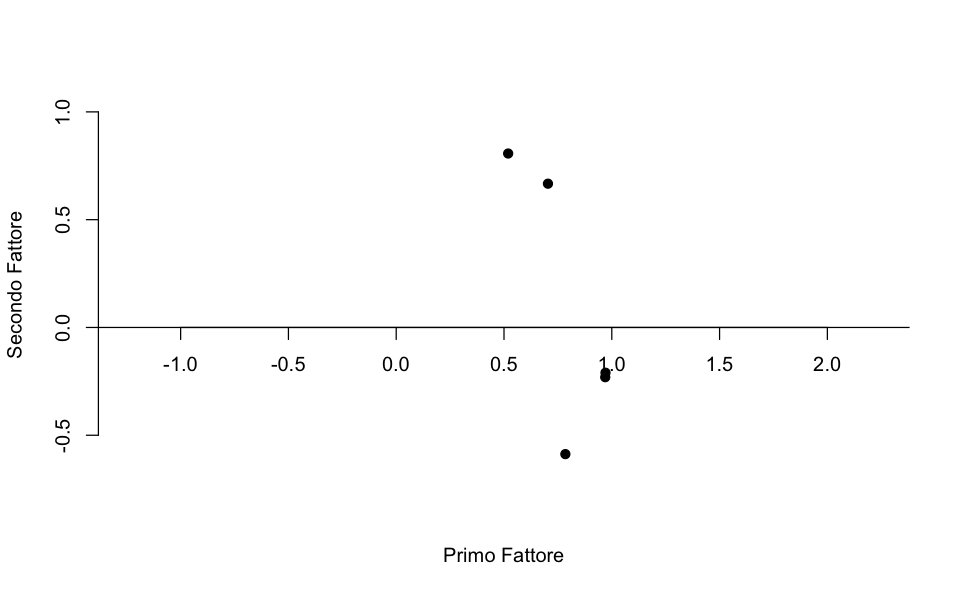

In [11]:
plot(
  f.pc$load[, 1], f.pc$load[, 2],
  bty = "n", xaxt = "n",
  xlab = "Primo Fattore", ylab = "Secondo Fattore",
  ylim = c(-.6, 1), xlim = c(0, 1), pch = 19, asp = 1
)
axis(1, pos = c(0, 0))
abline(0, 0)

@rencher10methods suggerisce che una rotazione ortogonale di $-35^\circ$ avvicinerebbe efficacemente gli assi ai punti nel diagramma di dispersione. Per verificarlo, si può disegnare i nuovi assi nel grafico dopo una rotazione di $-35^\circ$.

0.000,0.000
0.574,0.819
0.000,0.000
0.819,-0.574


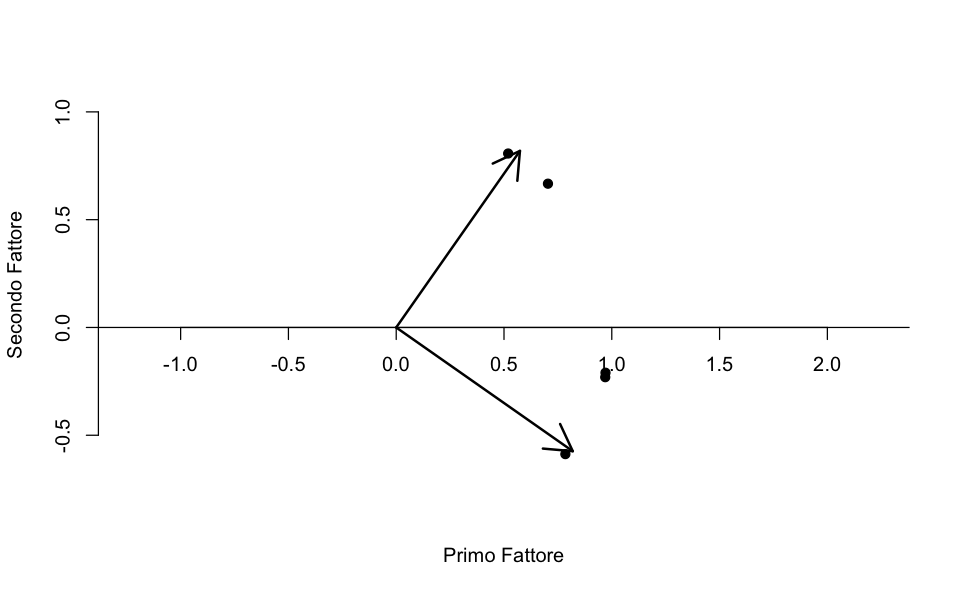

In [12]:
plot(
  f.pc$load[, 1], f.pc$load[, 2],
  bty = "n", xaxt = "n",
  xlab = "Primo Fattore", ylab = "Secondo Fattore",
  ylim = c(-.6, 1), xlim = c(0, 1), pch = 19, asp = 1
)
axis(1, pos = c(0, 0))
abline(0, 0)

ar <- matrix(c(
  0, 0,
  0, 1,
  0, 0,
  1, 0
), ncol = 2, byrow = TRUE)

angle <- 35
rad <- angle * pi / 180
T <- matrix(c(
  cos(rad), -sin(rad),
  sin(rad),  cos(rad)
), ncol = 2, byrow = TRUE)

round(ar %*% T, 3)

arrows(0, 0, 0.574, 0.819, lwd = 2)
arrows(0, 0, 0.819, -0.574, lwd = 2)


Nella figura, le due frecce rappresentano gli assi ruotati. La rotazione di $-35^{\circ}$ ha effettivamente avvicinato gli assi ai punti del diagramma. Se usiamo dunque il valore $\phi = -35^{\circ}$ nella matrice di rotazione, possiamo
calcolare le saturazioni fattoriali della soluzione ruotata
$\hat{\boldsymbol{\Lambda}}^* = \hat{\boldsymbol{\Lambda}} \textbf{T}$.

Le saturazioni fattoriali ruotate corrispondono alla proiezione
ortogonale dei punti sugli assi ruotati:

In [13]:
angle <- -35
rad <- angle * pi / 180
T <- matrix(c(
  cos(rad), -sin(rad),
  sin(rad),  cos(rad)
), ncol = 2, byrow = TRUE)
round(f.pc$load %*% T, 3)

K,0.927,0.367
I,-0.037,0.959
H,0.980,-0.031
L,0.916,0.385
J,0.194,0.950


La soluzione ottenuta in questo modo riproduce quanto riportato da
{cite:t}`rencher10methods`.


### Medodi di rotazione ortogonale

Un tipo di rotazione ortogonale spesso utilizzata è la rotazione Varimax
(Kaiser, 1958). La matrice $\hat{\boldsymbol{\Lambda}}$ è semplificata
in modo tale che le varianze dei quadrati degli elementi $\lambda_{ij}$
appartenenti a colonne diverse di $\hat{\boldsymbol{\Lambda}}$ siano
massime. Se le saturazioni fattoriali in una colonna di
$\hat{\boldsymbol{\Lambda}}$ sono simili tra loro, la varianza sarà
prossima a zero. Tale varianza è tanto più grande quanto più i quadrati
degli elementi $\lambda_{ij}$ assumono valori prossimi a $0$ e $1$.
Amplificando le correlazioni più alte e riducendo quelle più basse, la
rotazione Varimax agevola l'interpretazione di ciascun fattore.

Usando la funzione `factanal()` del modulo R base, la rotazione Varimax
può essere applicata alla soluzione ottenuta mediante il metodo di
massima verosimiglianza. Usando le funzioni `principal()` e
`factor.pa()` disponibili nel pacchetto `psych`, la rotazione Varimax
può essere applicata alle soluzioni ottenute mediante il metodo delle
componenti principali e il metodo del fattore principale. 

Ad esempio, usando il metodo delle componenti principali otteniamo:

In [14]:
f_pc <- principal(R, 2, n.obs = 7, rotate = "varimax")
f_pc

Principal Components Analysis
Call: principal(r = R, nfactors = 2, rotate = "varimax", n.obs = 7)
Standardized loadings (pattern matrix) based upon correlation matrix
   RC1   RC2   h2     u2 com
K 0.95  0.30 0.99 0.0067 1.2
I 0.03  0.96 0.92 0.0792 1.0
H 0.97 -0.10 0.96 0.0391 1.0
L 0.94  0.32 0.99 0.0135 1.2
J 0.26  0.93 0.94 0.0597 1.2

                       RC1  RC2
SS loadings           2.81 1.99
Proportion Var        0.56 0.40
Cumulative Var        0.56 0.96
Proportion Explained  0.58 0.42
Cumulative Proportion 0.58 1.00

Mean item complexity =  1.1
Test of the hypothesis that 2 components are sufficient.

The root mean square of the residuals (RMSR) is  0.03 
 with the empirical chi square  0.12  with prob <  0.73 

Fit based upon off diagonal values = 1

Un altro metodo di rotazione ortogonale è il metodo Quartimax (Neuhaus e Wringley, 1954), il quale opera una semplificazione della matrice $\hat{\boldsymbol{\Lambda}}$ massimizzando le covarianze tra i quadrati degli elementi $\lambda_{ij}$ appartenenti a righe diverse, subordinatamente alla condizione che la varianza delle righe
rimanga inalterata.

### Metodi di Rotazione Obliqua

Il termine "rotazione obliqua" può sembrare inappropriato, in quanto la rotazione implica generalmente una trasformazione ortogonale che preserva le distanze. Tuttavia, come evidenziato da {cite:t}`rencher10methods`, un'espressione più corretta potrebbe essere "trasformazione obliqua". Nonostante ciò, l'uso comune ha consolidato il termine "rotazione obliqua".

Nel contesto della rotazione obliqua, gli assi della soluzione ruotata non sono costretti a rimanere ortogonali tra loro, permettendo così un allineamento più diretto agli agglomerati di punti nello spazio delle saturazioni fattoriali. Questo tipo di trasformazione facilita l'interpretazione dei fattori in presenza di correlazioni tra di essi.

Esistono diversi approcci analitici per realizzare una rotazione obliqua. Ad esempio, il metodo Direct Oblimin, sviluppato da Jennrich e Sampson nel 1966, utilizza il seguente criterio:

$$
\sum_{ij} \left(\sum_v \lambda_i^2 \lambda_j^2 - w \frac{1}{p} \sum_v \lambda_i^2 \sum_v \lambda_j^2\right)
$$

Qui, $\sum_{ij}$ rappresenta la somma su tutte le coppie di fattori $ij$. Il processo prevede una minimizzazione, al contrario della massimizzazione tipica delle rotazioni ortogonali, riflettendo la ricerca di una soluzione che minimizzi la correlazione ridondante tra i fattori, mantenendo al contempo chiarezza interpretativa.

## Matrice dei Pesi Fattoriali e Matrice di Struttura

### Rotazione Ortogonale

Nel contesto della rotazione ortogonale, i fattori rimangono incorrelati tra loro. Consideriamo il caso di due fattori latenti non correlati ($\xi_1$ e $\xi_2$) e quattro variabili manifeste ($y_1, y_2, y_3, y_4$). I coefficienti $\lambda_{11}, \lambda_{12}, \lambda_{13}, \lambda_{14}$ rappresentano le saturazioni fattoriali delle variabili nel primo fattore, mentre $\lambda_{21}, \lambda_{22}, \lambda_{23}, \lambda_{24}$ sono quelle nel secondo fattore. In un modello di percorso, la correlazione tra due variabili è calcolata come la somma di tutti i percorsi validi che le collegano. Se i fattori comuni sono incorrelati, esiste un solo percorso valido che collega ciascuna variabile manifesta a ciascun fattore comune secondo le regole di Wright. Pertanto, le correlazioni tra variabili manifeste e fattori comuni sono direttamente uguali alle saturazioni fattoriali. Queste saturazioni possono essere interpretate come i pesi beta di un modello di regressione multipla, indicando il contributo specifico di ciascun fattore comune nella varianza spiegata degli item (Tabachnick & Fidell, 2001).

::: {#fig-rot_4}
![](../../figures/rot_4.png){width="50%"}

Rotazione ortogonale.
:::

### Rotazione Obliqua

Nel caso della rotazione obliqua, i fattori comuni risultano correlati tra loro, rendendo la soluzione fattoriale più complessa. Pertanto, la matrice delle saturazioni fattoriali non riflette più direttamente le correlazioni tra variabili e fattori. Un modello di percorso in questa configurazione include almeno due percorsi validi che collegano ciascuna variabile manifesta a ciascun fattore comune. È necessario distinguere tra tre matrici diverse:

- **Matrice Pattern ($\hat{\boldsymbol{\Lambda}}$)**: Conosciuta anche come matrice dei modelli, questa matrice rappresenta i coefficienti di regressione parziali delle variabili sulle dimensioni fattoriali, escludendo l'influenza degli altri fattori.
- **Matrice di Struttura**: Rappresenta le correlazioni complessive tra le variabili manifeste e i fattori, considerando sia gli effetti diretti che quelli indiretti dei fattori correlati.
- **Matrice di Intercorrelazione Fattoriale ($\hat{\boldsymbol{\Phi}}$)**: Indica le correlazioni tra i fattori stessi.

In un modello di percorso con rotazione obliqua, gli assi che rappresentano i fattori non sono ortogonali, il che significa che i fattori sono correlati. Le variabili manifeste sono quindi collegate ai fattori attraverso percorsi che includono effetti diretti e indiretti. Ad esempio, per la variabile $y_1$ e il fattore $\xi_1$, i percorsi includono una freccia causale $\lambda_{11}$ per l'effetto diretto e un percorso indiretto rappresentato dal prodotto $\lambda_{21}\phi_{12}$. L'analisi dei percorsi dimostra che la correlazione tra $\xi_1$ e $y_1$ è la somma dei valori numerici di questi percorsi validi, ovvero $\lambda_{11} + \lambda_{21} \phi_{12}$.

::: {#fig-rot_5}
![](../../figures/rot_5.png){width="50%"}

Rotazione obliqua.
:::

Per illustrare la rotazione obliqua, utilizziamo i dati discussi da
{cite:t}`rencher10methods`. Si consideri la matrice di correlazione presentata qui sotto.

In [15]:
R <- matrix(
  c(
    1.00,  0.735, 0.711, 0.704,
    0.735, 1.00,  0.693, 0.709,
    0.711, 0.693, 1.00,  0.839,
    0.704, 0.709, 0.839, 1.00
  ),
  ncol = 4,
  byrow = TRUE
)
R


1.000,0.735,0.711,0.704
0.735,1.000,0.693,0.709
0.711,0.693,1.000,0.839
0.704,0.709,0.839,1.000


Iniziamo calcolando la soluzione a due fattori mediante il metodo delle
componenti principali e una rotazione Varimax (ovvero, ortogonale). Otteniamo le seguenti saturazioni fattoriali.

In [16]:
f1_pc <- principal(R, 2, rotate = "varimax") 
f1_pc

Principal Components Analysis
Call: principal(r = R, nfactors = 2, rotate = "varimax")
Standardized loadings (pattern matrix) based upon correlation matrix
   RC1  RC2   h2    u2 com
1 0.50 0.78 0.86 0.140 1.7
2 0.47 0.81 0.88 0.124 1.6
3 0.90 0.33 0.92 0.078 1.3
4 0.89 0.35 0.92 0.083 1.3

                       RC1  RC2
SS loadings           2.08 1.50
Proportion Var        0.52 0.37
Cumulative Var        0.52 0.89
Proportion Explained  0.58 0.42
Cumulative Proportion 0.58 1.00

Mean item complexity =  1.5
Test of the hypothesis that 2 components are sufficient.

The root mean square of the residuals (RMSR) is  0.06 

Fit based upon off diagonal values = 0.99

Si noti che i due fattori non sono molto distinti. Consideriamo dunque la soluzione  prodotta da una rotazione obliqua. Usiamo qui l'algoritmo Oblimin.

In [17]:
pr_oblimin <- principal(R, 2, rotate = "oblimin")

Caricamento dei namespace richiesti: GPArotation



La matrice $\hat{\boldsymbol{\Lambda}}$ delle saturazioni fattoriali si ricava come indicato di seguito.

In [18]:
cbind(pr_oblimin$load[, 1], pr_oblimin$load[, 2])

0.03206780,0.90186261
-0.02543116,0.95556536
0.96858605,-0.01096737
0.94726778,0.01327683


La matrice $\hat{\boldsymbol{\Phi}}$ di inter-correlazione fattoriale è la seguente.

In [19]:
pr_oblimin$Phi

,TC1,TC2
TC1,1.0000000,0.7869776
TC2,0.7869776,1.0000000


La matrice di struttura, che riporta le correlazioni tra indicatori e fattori comuni, si ottiene pre-moltiplicando la matrice $\boldsymbol{\Lambda}$ delle saturazioni fattoriali alla matrice $\boldsymbol{\Phi}$ di inter-correlazione fattoriale.

$$
\text{matrice di struttura} = \boldsymbol{\Lambda}\boldsymbol{\Phi}.
$$

Per esempio, la correlazione tra la prima variabile manifesta e il primo fattore si ottiene nel modo seguente.

In [20]:
pr_oblimin$load[1, 1] + pr_oblimin$load[1, 2] * pr_oblimin$Phi[2, 1]

TC1 
0.7418135

L'intera matrice di struttura si può trovare eseguendo la moltiplicazione  $\boldsymbol{\Lambda}\boldsymbol{\Phi}$.

In [21]:
pr_oblimin$load %*% pr_oblimin$Phi %>% 
  round(3)

TC1,TC2
0.742,0.927
0.727,0.936
0.960,0.751
0.958,0.759


## Esempio con `semTools`

Presento qui un esempio di uso di vari metodi di estrazione fattoriale. Tra tali  metodi, la rotazione obliqua Geomin è molto popolare ed è il default di M-Plus. 

Iniziamo a caricare il pacchetto `semTools`.

In [22]:
suppressPackageStartupMessages(library("semTools")) 

Eseguiamo l'analisi fattoriale esplorativa del classico set di dati di Holzinger e Swineford (1939) il quale è costituito dai punteggi dei test di abilità mentale di bambini di seconda e terza media di due scuole diverse (Pasteur e Grant-White). Nel set di dati originale (disponibile nel pacchetto `MBESS`), sono forniti i punteggi di 26 test. Tuttavia, un sottoinsieme più piccolo con 9 variabili è più ampiamente utilizzato in letteratura. Questi sono i dati qui usati. 

Nel presente esempio, verrà eseguita l'analisi fattoriale esplorativa con l'estrazione di tre fattori. Il metodo di estrazione è `mlr`:

> maximum likelihood estimation with robust (Huber-White) standard errors and a scaled test statistic that is (asymptotically) equal to the Yuan-Bentler test statistic. For both complete and incomplete data.

La soluzione iniziale non è ruotata. 

In [25]:
unrotated <- efaUnrotate(
    HolzingerSwineford1939, 
    nf = 3, 
    varList = paste0("x", 1:9), 
    estimator = "mlr"
)
out <- summary(unrotated)
print(out)

lavaan 0.6-18 ended normally after 217 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        36

  Number of observations                           301

Model Test User Model:
                                              Standard      Scaled
  Test Statistic                                22.897      23.864
  Degrees of freedom                                12          12
  P-value (Chi-square)                           0.029       0.021
  Scaling correction factor                                  0.959
    Yuan-Bentler correction (Mplus variant)                       

Parameter Estimates:

  Standard errors                             Sandwich
  Information bread                           Observed
  Observed information based on                Hessian

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  factor1 =~                            

Si noti che, in assenza di rotazione, è impossibile assegnare un significato ai fattori comuni.

### Orthogonal varimax

Utilizziamo ora la rotazione ortogonale Varimax.

In [26]:
out_varimax <- orthRotate(
    unrotated, 
    method = "varimax"
)
out <- summary(out_varimax, sort = FALSE, suppress = 0.3)
print(out)

Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


   factor1 factor2 factor3
x1  0.320*  0.607*        
x2          0.481*        
x3          0.662*        
x4  0.838*                
x5  0.867*                
x6  0.815*                
x7                  0.695*
x8                  0.704*
x9          0.409*  0.511*

Factor Correlation
        factor1 factor2 factor3
factor1       1       0       0
factor2       0       1       0
factor3       0       0       1

Method of rotation:	varimax 

Test Statistics for Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


       lhs op rhs std.loading    se      z     p ci.lower ci.upper
1  factor1 =~  x1       0.320 0.055  5.799 0.000    0.212    0.428
2  factor1 =~  x2       0.135 0.063  2.151 0.031    0.012    0.259
3  factor1 =~  x3       0.080 0.049  1.622 0.105   -0.017    0.176
4  factor1 =~  x4       0.838 0.028 30.193 0.000    0.784    0.892
5  factor1 =~  x5       0.867 0.024 36.189 0.000    0.820    0.914
6  factor1 =~  x6       0.815 0.024 33.939 0.000    0.768    0.862
7  factor1 =~  x7       0.102 0.049  2.058 0.040    0.005    0.199
8  factor1 =~  x8       0.078 0.048  1.617 0.106   -0.016    0.172
9  factor1 =~  x9       0.170 0.053  3.222 0.001    0.067    0.273
10 factor2 =~  x1       0.607 0.075  8.138 0.000    0.461    0.753
11 factor2 =~  x2       0.481 0.067  7.184 0.000    0.350    0.612
12 factor2 =~  x3       0.662 0.058 11.499 0.000    0.549    0.775
13 factor2 =~  x4       0.113 0.043  2.615 0.009    0.028    0.198
14 factor2 =~  x5       0.032 0.040  0.802 0.422   -0.047    0

### Orthogonal Quartimin

Un metodo alternativo per la rotazione ortogonale è Quartimin.

In [27]:
out_quartimin <- orthRotate(
    unrotated, 
    method = "quartimin"
)
out <- summary(out_quartimin, sort = FALSE, suppress = 0.3)
print(out)

Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


   factor1 factor2 factor3
x1  0.353*  0.590*        
x2          0.474*        
x3          0.657*        
x4  0.844*                
x5  0.869*                
x6  0.823*                
x7                  0.692*
x8                  0.702*
x9          0.397*  0.508*

Factor Correlation
        factor1 factor2 factor3
factor1       1       0       0
factor2       0       1       0
factor3       0       0       1

Method of rotation:	Quartimin 

Test Statistics for Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


       lhs op rhs std.loading    se      z     p ci.lower ci.upper
1  factor1 =~  x1       0.353 0.062  5.720 0.000    0.232    0.473
2  factor1 =~  x2       0.158 0.066  2.375 0.018    0.028    0.288
3  factor1 =~  x3       0.115 0.057  2.015 0.044    0.003    0.226
4  factor1 =~  x4       0.844 0.027 30.814 0.000    0.790    0.898
5  factor1 =~  x5       0.869 0.023 37.224 0.000    0.823    0.914
6  factor1 =~  x6       0.823 0.024 35.026 0.000    0.777    0.869
7  factor1 =~  x7       0.116 0.054  2.161 0.031    0.011    0.222
8  factor1 =~  x8       0.104 0.054  1.914 0.056   -0.003    0.210
9  factor1 =~  x9       0.202 0.059  3.403 0.001    0.086    0.319
10 factor2 =~  x1       0.590 0.078  7.523 0.000    0.436    0.743
11 factor2 =~  x2       0.474 0.068  6.935 0.000    0.340    0.608
12 factor2 =~  x3       0.657 0.059 11.204 0.000    0.542    0.771
13 factor2 =~  x4       0.072 0.041  1.748 0.080   -0.009    0.152
14 factor2 =~  x5      -0.010 0.039 -0.263 0.793   -0.087    0

### Oblique Quartimin

L'algoritmo Quartimin può anche essere usato per una soluzione obliqua.

In [28]:
out_oblq <- oblqRotate(
    unrotated, 
    method = "quartimin"
)
out <- summary(out_oblq, sort = FALSE, suppress = 0.3)
print(out)

Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


   factor1 factor2 factor3
x1          0.602*        
x2          0.505*        
x3          0.689*        
x4  0.840*                
x5  0.888*                
x6  0.808*                
x7                  0.723*
x8                  0.702*
x9          0.366*  0.463*

Factor Correlation
          factor1   factor2   factor3
factor1 1.0000000 0.3257795 0.2164265
factor2 0.3257795 1.0000000 0.2704806
factor3 0.2164265 0.2704806 1.0000000

Method of rotation:	Quartimin 

Test Statistics for Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


       lhs op rhs std.loading    se      z     p ci.lower ci.upper
1  factor1 =~  x1       0.191 0.064  2.965 0.003    0.065    0.317
2  factor1 =~  x2       0.044 0.066  0.665 0.506   -0.085    0.172
3  factor1 =~  x3      -0.070 0.034 -2.031 0.042   -0.137   -0.002
4  factor1 =~  x4       0.840 0.033 25.622 0.000    0.776    0.905
5  factor1 =~  x5       0.888 0.027 32.583 0.000    0.835    0.942
6  factor1 =~  x6       0.808 0.028 28.441 0.000    0.752    0.863
7  factor1 =~  x7       0.044 0.037  1.179 0.238   -0.029    0.116
8  factor1 =~  x8      -0.033 0.036 -0.916 0.360   -0.103    0.037
9  factor1 =~  x9       0.035 0.048  0.728 0.467   -0.059    0.129
10 factor2 =~  x1       0.602 0.086  7.003 0.000    0.434    0.771
11 factor2 =~  x2       0.505 0.071  7.163 0.000    0.367    0.644
12 factor2 =~  x3       0.689 0.056 12.344 0.000    0.580    0.799
13 factor2 =~  x4       0.022 0.045  0.483 0.629   -0.067    0.110
14 factor2 =~  x5      -0.067 0.036 -1.890 0.059   -0.137    0

### Orthogonal Geomin

Consideriamo ora la rotazione Geomin. L'algoritmo Geomin fornisce un metodo di rotazione che riduce al minimo la media geometrica delle saturazioni fattoriali innalzate al quadrato. Qui è usato per ottenere una soluzione ortogonale.

In [29]:
out_geomin_orh <- orthRotate(
    unrotated, 
    method = "geomin"
)
out <- summary(out_geomin_orh, sort = FALSE, suppress = 0.3)
print(out)

Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


   factor1 factor2 factor3
x1  0.315*         -0.621*
x2                 -0.474*
x3                 -0.671*
x4  0.838*                
x5  0.867*                
x6  0.814*                
x7          0.696*        
x8          0.677*        
x9          0.456* -0.468*

Factor Correlation
        factor1 factor2 factor3
factor1       1       0       0
factor2       0       1       0
factor3       0       0       1

Method of rotation:	Geomin 

Test Statistics for Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


       lhs op rhs std.loading    se       z     p ci.lower ci.upper
1  factor1 =~  x1       0.315 0.134   2.352 0.019    0.053    0.578
2  factor1 =~  x2       0.130 0.118   1.102 0.271   -0.101    0.360
3  factor1 =~  x3       0.074 0.123   0.599 0.549   -0.168    0.316
4  factor1 =~  x4       0.838 0.036  23.402 0.000    0.767    0.908
5  factor1 =~  x5       0.867 0.025  35.190 0.000    0.819    0.915
6  factor1 =~  x6       0.814 0.040  20.427 0.000    0.736    0.892
7  factor1 =~  x7       0.112 0.068   1.645 0.100   -0.021    0.245
8  factor1 =~  x8       0.085 0.063   1.341 0.180   -0.039    0.209
9  factor1 =~  x9       0.172 0.095   1.803 0.071   -0.015    0.359
10 factor2 =~  x1       0.053 0.061   0.868 0.386   -0.067    0.173
11 factor2 =~  x2      -0.099 0.070  -1.409 0.159   -0.237    0.039
12 factor2 =~  x3       0.033 0.048   0.698 0.485   -0.060    0.127
13 factor2 =~  x4       0.051 0.046   1.115 0.265   -0.039    0.140
14 factor2 =~  x5       0.054 0.061   0.878 0.38

### Oblique Geomin

La rotazione Geomin può anche essere usata per ottenere una soluzione obliqua.

In [30]:
out_geomin_obl <- oblqRotate(
    unrotated, 
    method = "geomin"
)
out <- summary(out_geomin_obl, sort = FALSE, suppress = 0.3)
print(out)

Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


   factor1 factor2 factor3
x1                 -0.604*
x2                 -0.507*
x3                 -0.691*
x4  0.839*                
x5  0.887*                
x6  0.806*                
x7          0.726*        
x8          0.703*        
x9          0.463* -0.368*

Factor Correlation
           factor1    factor2    factor3
factor1  1.0000000  0.2296081 -0.3271571
factor2  0.2296081  1.0000000 -0.2776987
factor3 -0.3271571 -0.2776987  1.0000000

Method of rotation:	Geomin 

Test Statistics for Standardized Rotated Factor Loadings


Warning message in testLoadings(object):
"The standard error is currently invalid because it does not account for the variance of the rotation function. It is simply based on the delta method."


       lhs op rhs std.loading    se       z     p ci.lower ci.upper
1  factor1 =~  x1       0.188 0.070   2.670 0.008    0.050    0.326
2  factor1 =~  x2       0.044 0.054   0.806 0.420   -0.063    0.150
3  factor1 =~  x3      -0.073 0.049  -1.467 0.142   -0.170    0.024
4  factor1 =~  x4       0.839 0.032  26.467 0.000    0.777    0.901
5  factor1 =~  x5       0.887 0.029  30.077 0.000    0.829    0.945
6  factor1 =~  x6       0.806 0.030  26.717 0.000    0.747    0.865
7  factor1 =~  x7       0.031 0.034   0.915 0.360   -0.036    0.099
8  factor1 =~  x8      -0.045 0.048  -0.948 0.343   -0.139    0.048
9  factor1 =~  x9       0.025 0.034   0.747 0.455   -0.041    0.091
10 factor2 =~  x1       0.029 0.051   0.567 0.571   -0.071    0.129
11 factor2 =~  x2      -0.119 0.072  -1.664 0.096   -0.260    0.021
12 factor2 =~  x3       0.020 0.037   0.538 0.591   -0.053    0.092
13 factor2 =~  x4       0.007 0.043   0.174 0.862   -0.076    0.091
14 factor2 =~  x5       0.010 0.036   0.285 0.77

## Interpretazione dei fattori latenti nell'analisi fattoriale

Nell'interpretare i fattori comuni latenti in un'analisi fattoriale, è cruciale scegliere tra la matrice pattern e la matrice struttura. Entrambe sono utili per l'interpretazione, ma forniscono informazioni diverse:

1. **Matrice pattern**:

   - Mostra le **saturazioni fattoriali** dirette.
   - Indica gli effetti diretti dei fattori latenti sulle variabili manifeste.
   - Rivela quanto ciascun fattore contribuisce direttamente alla varianza di una variabile osservata.
   - Fondamentale per comprendere il significato psicologico dei fattori.

2. **Matrice struttura**:

   - Rappresenta le **correlazioni** tra fattori latenti e variabili osservate.
   - Include sia gli **effetti diretti** che quelli **indiretti**.
   - Descrive la covariazione complessiva tra fattori e variabili manifeste.
   - Non distingue tra relazioni dirette e indirette.

Un fattore identificato nell'analisi fattoriale rappresenta una variabile latente univariata, ovvero una dimensione sottostante che cattura l'essenza di un fenomeno psicologico. L'interpretazione del fattore emerge dall'intersezione dei significati delle variabili che vi saturano.

Nel caso di rotazioni oblique, dove i fattori sono correlati, è essenziale interpretare ogni fattore come una dimensione psicologica distinta. Ad esempio, l'etichetta assegnata al fattore $F_1$ deve essere concettualmente separata dal fenomeno rappresentato dal fattore $F_2$, nonostante la loro correlazione.

Adottando questa strategia interpretativa, la matrice pattern diventa lo strumento principale per l'interpretazione. I suoi coefficienti riflettono gli effetti diretti dei fattori latenti sulle variabili manifeste, indicando un'influenza "causale" del fattore su tali variabili. La matrice struttura, invece, descrive le correlazioni complessive tra variabili manifeste e fattori, includendo sia relazioni dirette che indirette.

In conclusione, per un'interpretazione più accurata e teoricamente solida dei fattori latenti, è preferibile basarsi sulla matrice pattern, che fornisce informazioni specifiche sugli effetti diretti tra fattori comuni e variabili manifeste.